# 📰 News Category Classification

This notebook tackles a multi-class classification task using news headlines and short descriptions from the HuffPost dataset.

My goal is to predict the category of a news article based on its text. I explore both classical and deep learning models, including:

- A Linear Support Vector Machine (SVM) using TF-IDF features and TruncatedSVD
- Deep learning models (CNN, LSTM, GRU) using pretrained GloVe embeddings
- Hyperparameter tuning with Keras Tuner for optimal CNN performance

I preprocess the text, address category imbalance, and compare the models based on accuracy and weighted F1-score.


## Step 0: Environment & Libraries

I began by importing the necessary libraries. These include:
- **Data handling** tools like pandas and numpy
- **Text processing** with `nltk` and `spaCy`
- **Machine learning** components, including `TruncatedSVD` (used instead of PCA because TF-IDF vectors are sparse), `LinearSVC`, and model evaluation metrics
- **Deep learning** with TensorFlow and Keras
- **Pretrained embeddings** (we'll use GloVe)
- **Progress tracking** with tqdm
- **Hyperparameter tuning** with Keras Tuner

In [1]:
# Data handling and utilities
import numpy as np
import pandas as pd
import json
import re
from collections import Counter

# Text preprocessing
import nltk
import spacy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: Classical models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  # Dimensionality reduction for sparse TF-IDF
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Progress tracking and hyperparameter tuning
from tqdm import tqdm
import keras_tuner as kt

### Set seeds for reproducibility

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### NLP Setup: Download NLTK & Load spaCy model to work with stopwords 

To lemmatize text using spaCy, I used the small English model `en_core_web_sm`.

If you're running this notebook for the first time, you may need to install the model manually using the command below in your terminal or command prompt (outside of the notebook):


In [3]:
# Uncomment these lines if you're running this for the first time
# !python -m spacy download en_core_web_sm
# nltk.download('stopwords')
# nltk.download('punkt')

stop_words = set(nltk.corpus.stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

## Step 1: Data Ingestion & Category Cleaning

I use the HuffPost News Category Dataset, which is stored in JSON lines format. Each line represents a news article with fields like `headline`, `short_description`, `category`, `link`, and `date`.

I begin by loading the data into a pandas DataFrame and inspecting the first few rows to understand its structure.

### 1.1 Load JSON Data and Create DataFrame

In [4]:
# Load JSON lines from data directory
data = []
with open('../data/news_category_dataset.json', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Display first few rows
df.head()


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


### 1.2: Combine headline and short_description

The dataset includes both a `headline` and a `short_description` column. I concatenate these two fields into a new column called `text`, which will be the input for all models.

In [5]:
# Combine headline and short_description into a single field
df['text'] = df['headline'].fillna('') + ' ' + df['short_description'].fillna('')

### 1.3 Preview Existing Categories

In [6]:
# Show all unique categories and their frequencies
category_counts = df['category'].value_counts()
print("Total unique categories:", len(category_counts))
print("\nCategory distribution:\n")
print(category_counts)

# Optional: display normalized proportions
print("\nNormalized proportions:\n")
print((category_counts / len(df)).round(4))


Total unique categories: 42

Category distribution:

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LA

### 1.4 Merge Semantically Similar Categories

The original dataset contains 42 categories, many of which are semantically redundant or too granular (e.g., `"STYLE"` vs. `"STYLE & BEAUTY"`, `"THE WORLDPOST"` vs. `"WORLDPOST"`). These overlaps create label noise and increase sparsity.

I merged these categories to:
- Reduce semantic redundancy
- Minimize class imbalance and data sparsity
- Improve model learnability by having fewer, more distinct target labels


To improve model clarity and balance, I merged overlapping categories, ro reduce semantic redundancy, minimize class imbalance and data sparsity and to improve model learnability by having fewer, more distinct target labels. 

I also dropped very rare categories (e.g., `"LATINO VOICES"`), and then encoded the cleaned labels into numerical format using `LabelEncoder`.


In [7]:
# Merge semantically similar categories
category_merge_map = {
    'ARTS': 'ARTS & CULTURE',
    'CULTURE & ARTS': 'ARTS & CULTURE',
    'PARENTS': 'PARENTING',
    'THE WORLDPOST': 'WORLD NEWS',
    'WORLDPOST': 'WORLD NEWS',
    'STYLE': 'STYLE & BEAUTY',
    'HEALTHY LIVING': 'WELLNESS',
    'TASTE': 'FOOD & DRINK',
    'GREEN': 'ENVIRONMENT',
    'COLLEGE': 'EDUCATION',
    'FIFTY': 'WELLNESS',
    'GOOD NEWS': 'IMPACT',
    'U.S. NEWS': 'POLITICS'
}

# Apply the mapping
df['category'] = df['category'].replace(category_merge_map)

# Category Count
print(df['category'].value_counts())
print("New number of categories:", df['category'].nunique())


category
POLITICS          36979
WELLNESS          26040
ENTERTAINMENT     17362
PARENTING         12746
STYLE & BEAUTY    12068
TRAVEL             9900
WORLD NEWS         9542
FOOD & DRINK       8436
QUEER VOICES       6347
BUSINESS           5992
COMEDY             5400
SPORTS             5077
IMPACT             4882
BLACK VOICES       4583
HOME & LIVING      4320
ENVIRONMENT        4066
ARTS & CULTURE     3922
WEDDINGS           3653
WOMEN              3572
CRIME              3562
DIVORCE            3426
MEDIA              2944
WEIRD NEWS         2777
RELIGION           2577
SCIENCE            2206
EDUCATION          2158
TECH               2104
MONEY              1756
LATINO VOICES      1130
Name: count, dtype: int64
New number of categories: 29


After merging, the number of unique categories dropped from 42 to 28, making the task more tractable.

### 1.5 Remove out-of-scope categories

In [8]:
# Drop rare or out-of-scope categories
drop_categories = ['LATINO VOICES']
df = df[~df['category'].isin(drop_categories)]


### 1.6 Encode Categories as Numeric Labels

In [9]:
# If you have named categories (e.g., "COMEDY", "U.S. NEWS")
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])  # or df['Class Index'] if CSV has numbers

# View label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_map)

# Show updated dataframe
df[['text', 'category', 'label']].head()


{'ARTS & CULTURE': np.int64(0), 'BLACK VOICES': np.int64(1), 'BUSINESS': np.int64(2), 'COMEDY': np.int64(3), 'CRIME': np.int64(4), 'DIVORCE': np.int64(5), 'EDUCATION': np.int64(6), 'ENTERTAINMENT': np.int64(7), 'ENVIRONMENT': np.int64(8), 'FOOD & DRINK': np.int64(9), 'HOME & LIVING': np.int64(10), 'IMPACT': np.int64(11), 'MEDIA': np.int64(12), 'MONEY': np.int64(13), 'PARENTING': np.int64(14), 'POLITICS': np.int64(15), 'QUEER VOICES': np.int64(16), 'RELIGION': np.int64(17), 'SCIENCE': np.int64(18), 'SPORTS': np.int64(19), 'STYLE & BEAUTY': np.int64(20), 'TECH': np.int64(21), 'TRAVEL': np.int64(22), 'WEDDINGS': np.int64(23), 'WEIRD NEWS': np.int64(24), 'WELLNESS': np.int64(25), 'WOMEN': np.int64(26), 'WORLD NEWS': np.int64(27)}


,text,category,label
0,Over 4 Million Americans Roll Up Sleeves For O...,POLITICS,15
1,"American Airlines Flyer Charged, Banned For Li...",POLITICS,15
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,3
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,14
4,Woman Who Called Cops On Black Bird-Watcher Lo...,POLITICS,15


### 1.7 Save the Full Cleaned Dataset

In [10]:
df.to_csv("cleaned_dataset.csv", index=False)

## Step 2: Exploratory Data Analysis (EDA)

I analyze the distribution of categories and article lengths to understand data characteristics and support key modeling choices. This includes:

- Visualizing class imbalance across categories
- Identifying empty or extremely short entries
- Understanding typical text lengths (word count)

### 2.1 Plot Class Distribution for each categories

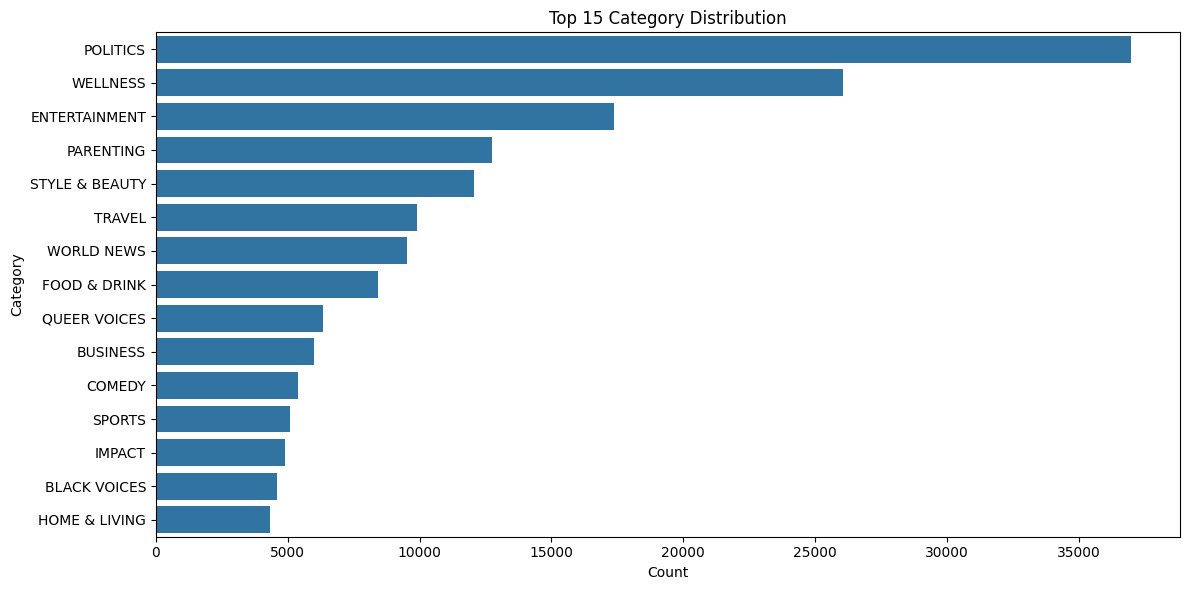

Number of categories: 28
Normalized category counts:
 category
POLITICS          36979
WELLNESS          26040
ENTERTAINMENT     17362
PARENTING         12746
STYLE & BEAUTY    12068
TRAVEL             9900
WORLD NEWS         9542
FOOD & DRINK       8436
QUEER VOICES       6347
BUSINESS           5992
COMEDY             5400
SPORTS             5077
IMPACT             4882
BLACK VOICES       4583
HOME & LIVING      4320
ENVIRONMENT        4066
ARTS & CULTURE     3922
WEDDINGS           3653
WOMEN              3572
CRIME              3562
DIVORCE            3426
MEDIA              2944
WEIRD NEWS         2777
RELIGION           2577
SCIENCE            2206
EDUCATION          2158
TECH               2104
MONEY              1756
Name: count, dtype: int64


In [11]:
# Plot the top 15 most common categories to illustrate class imbalance
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index[:15])
plt.title("Top 15 Category Distribution")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# Print total number of categories and their frequency counts
print("Number of categories:", df['category'].nunique())
print("Normalized category counts:\n", df['category'].value_counts())


### 2.2 Check for Missing Values


In [12]:
# Missing values summary
print("Missing Values:\n", df.isnull().sum())

# Distribution of empty texts
print("Empty text rows:", (df['text'].str.strip() == '').sum())




Missing Values:
 link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
text                 0
label                0
dtype: int64
Empty text rows: 5


**Note:** While no `NaN` values were found, I discovered 5 rows where the `text` field was an empty string.
These were removed from the dataset to avoid passing blank inputs into downstream models.


In [13]:
# Remove rows with empty 'text' values (even if not null)
df = df[~(df['text'].str.strip() == '')]

# Distribution of empty texts
print("Empty text rows:", (df['text'].str.strip() == '').sum())

Empty text rows: 0


### 2.3 Analyze Text Length (Word Count)

Most articles are short. I compute word counts per row and examine the distribution to support decisions like padding length.

Word Count Stats:
 count    208392.000000
mean         29.285515
std          13.811479
min           1.000000
25%          20.000000
50%          28.000000
75%          35.000000
max         245.000000
Name: word_count, dtype: float64


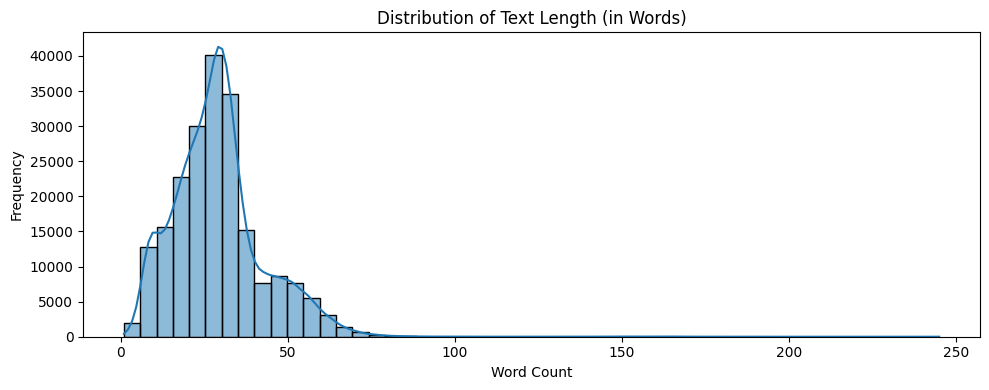

95th percentile of word count: 55.0


In [14]:
# Add basic length stats
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Summary stats
print("Word Count Stats:\n", df['word_count'].describe())

# Histogram of word counts
plt.figure(figsize=(10, 4))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Distribution of Text Length (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Visualize the 95th percentile word count to support the 100-token sequence length
p95 = df['word_count'].quantile(0.95)
print("95th percentile of word count:", p95)


### 2.4 Average Word Count by Category

Certain categories (like WELLNESS or MONEY) tend to have longer texts. This justifies setting a slightly generous sequence length (e.g., 100 tokens) in the deep learning models.

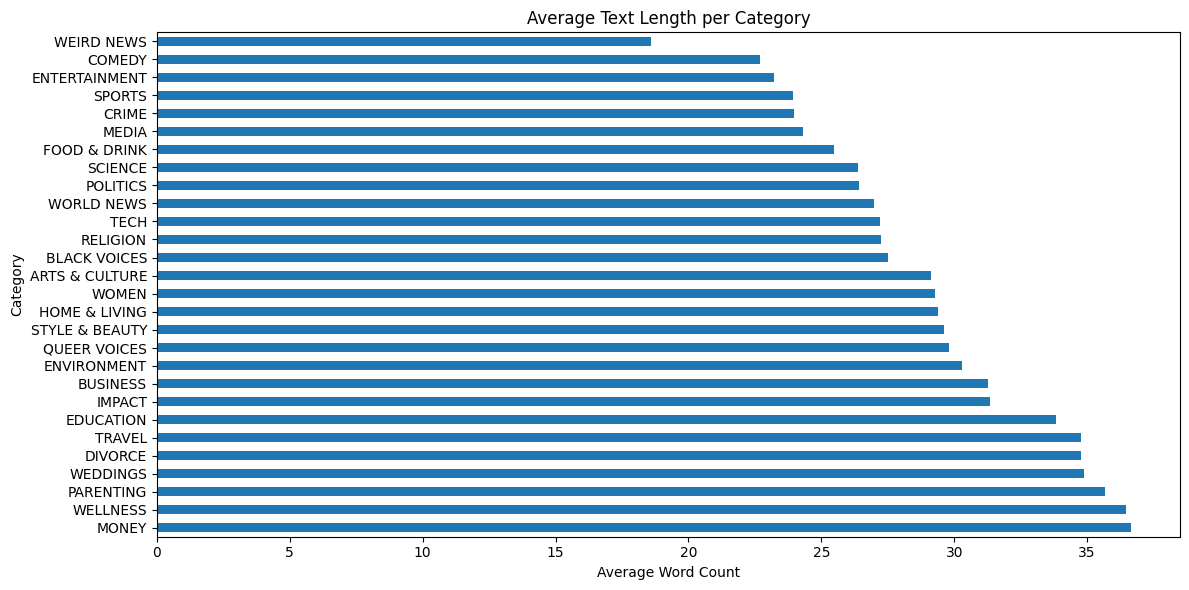

In [15]:
# Average length per category
category_wc = df.groupby('category')['word_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
category_wc.plot(kind='barh')
plt.title("Average Text Length per Category")
plt.xlabel("Average Word Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


Based on the EDA above:
- The **average article text length** is around 29 words, with most falling between 20 and 35 words (and 95% of them below 55 words).
- A few longer entries extend up to 245 words, but these are outliers.
- Some categories (like MONEY or WELLNESS) contain slightly longer descriptions on average.

To account for this, I chose:
- `MAX_SEQUENCE_LENGTH = 100` in the deep learning models, which allows coverage for nearly all samples without excessive padding.
- I used a **sample of 50,000 rows** for training due to compute constraints, but this can easily be scaled up to +200k in future runs.

These choices were based on a balance between capturing enough context and maintaining training efficiency.


### 2.5 Display Example Snippets by Category

In [16]:
# Show 1 example per category
example_snippets = df.groupby('category')['text'].apply(lambda x: x.sample(1).values[0])
for cat, text in example_snippets.items():
    print(f"--- {cat} ---")
    print(text[:300], '...\n')


--- ARTS & CULTURE ---
Learning From the Masters If you want to see an example of creativity as "intelligence having fun," watch the opening sequence from 1920's The Scarecrow as the 5'6" Buster Keaton and 6'3" Joe Roberts sit down to one of the most elaborately choreographed breakfasts you will ever see in your life. ...

--- BLACK VOICES ---
3 Black Teen Finalists In NASA Competition Targeted By Racist Hackers The trolls tried to hack the competition's voting system to favor teenage boys. ...

--- BUSINESS ---
Walmart Women Still Seek Justice In Sex Discrimination Case "When the Supreme Court's decision came down, Walmart announced that the case was over," said Joseph Sellers, co-lead counsel ...

--- COMEDY ---
Trevor Noah Has Spotted A Funny Musical Thing About Donald Trump's Speech Patterns Lively up yourself for this impression. ...

--- CRIME ---
5 Years After Miller v. Alabama, Looking To The States For Justice Five years ago this week, as another term of the United States Supr

## Step 3: Text Preprocessing using spaCy

To prepare the data for modeling, I apply the following preprocessing steps:

- Lowercasing and character filtering (retain letters, numbers, `$`, and `#`)
- Lemmatization using `spaCy`
- Stopword and punctuation removal using `nltk` and `spaCy`
- Removal of short and irrelevant tokens (e.g., length ≤ 2)

Lemmatization standardizes words (e.g., “running” → “run”) and improves generalization. I used `spaCy`'s `nlp.pipe()` method to process texts in batches efficiently.

Because processing the full dataset is computationally expensive, I used a random sample of 50,000 articles for model development.


### 3.1 Define a basic cleaning function to lowercase and remove non-letter characters

In [17]:
# Basic cleaning: lowercase text and remove non-alphanumeric characters (except $ and #)
def clean_for_spacy(text):
    text = text.lower()
    # Keep words, digits, $ and # symbols
    text = re.sub(r'[^a-z0-9$#\s]', '', text)
    return text

### 3.2 Fast preprocessing using spaCy's nlp.pipe for lemmatization

In [18]:
# Apply spaCy lemmatization and filter tokens
def fast_preprocess(texts):
    cleaned_texts = [clean_for_spacy(t) for t in texts]
    docs = nlp.pipe(cleaned_texts, batch_size=64)
    return [
        ' '.join(
            token.lemma_ for token in doc 
            if token.lemma_ not in stop_words and len(token) > 2 and not token.is_stop and not token.is_punct
        )
        for doc in docs
    ]

### 3.3 Choose Dataset Version

To speed up experimentation, I randomly sample 50,000 rows from the cleaned dataset. This sample maintains class proportions due to stratified splitting later.

In [19]:
# Option 1: Process the full dataset (this is very slow, it took me 8 hours to run...)
# df['clean_text'] = fast_preprocess(df['text'])

# Option 2: Use a 50k-row sample for faster processing
df_sample = df.sample(n=50000, random_state=42).copy()

### 3.4 Enhanced preprocessing with tqdm progress tracking

In [20]:
# Apply spaCy lemmatization and filter tokens
def fast_preprocess_with_tqdm(texts):
    cleaned_texts = [clean_for_spacy(t) for t in texts]
    docs = list(tqdm(nlp.pipe(cleaned_texts, batch_size=64), total=len(cleaned_texts)))
    results = []
    for doc in docs:
        tokens = [
            token.lemma_ for token in doc
            if len(token) > 2 and token.is_alpha and not token.is_stop and token.lemma_ not in stop_words
        ]
        results.append(' '.join(tokens))
    return results

# Apply cleaning and lemmatization
df_sample['clean_text'] = fast_preprocess_with_tqdm(df_sample['text'])

100%|██████████| 50000/50000 [02:01<00:00, 410.98it/s]


### 3.5 Save the preprocessed sample for future use

In [21]:
# Save for reuse
df_sample.to_csv("cleaned_sample_dataset.csv", index=False)

### 3.6 Check Most Common Words

In [22]:
# Combine all tokens
all_tokens = ' '.join(df_sample['clean_text']).split()
common_words = Counter(all_tokens).most_common(20)

# Display
print("Most common words:", common_words)


Most common words: [('new', 4644), ('trump', 4543), ('say', 3752), ('photo', 3378), ('day', 3337), ('year', 3300), ('time', 3283), ('people', 3116), ('good', 3028), ('like', 2872), ('life', 2657), ('know', 2640), ('way', 2605), ('want', 2477), ('look', 2204), ('woman', 2161), ('need', 2140), ('find', 2136), ('world', 2121), ('thing', 2086)]


## Step 4: Data Splitting (Train/Validation/Test)

To evaluate models fairly, I split the dataset into three sets:

- **70% for training**: Used to fit the model
- **15% for validation**: Used to tune hyperparameters and monitor overfitting
- **15% for testing**: Held out for final evaluation

I also used **stratified sampling** to preserve the original category distribution across all splits. This is important for multi-class classification tasks with imbalance (e.g., POLITICS has far more samples than MONEY or SCIENCE).

Although I experimented with other splits (like 80/10/10), I found 70/15/15 to provide a more reliable validation set without sacrificing too much training data.


In [23]:

# Step 0: Use the sample dataset for subsequent modeling
sample_df = df_sample.copy()  # contains 'text', 'label', and 'clean_text'

# Step 1: Split into train (70%) and temp (30%)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    sample_df['text'], sample_df['label'], 
    test_size=0.30, 
    stratify=sample_df['label'], 
    random_state=42
)

# Step 2: Split temp into validation (15%) and test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, 
    test_size=0.50, 
    stratify=temp_labels, 
    random_state=42
)

# Step 3: Recover full rows for each split
# Building DataFrames by locating rows using boolean indexing
train_df = sample_df[sample_df['text'].isin(train_texts)].copy()
val_df = sample_df[sample_df['text'].isin(val_texts)].copy()
test_df = sample_df[sample_df['text'].isin(test_texts)].copy()

# Step 4: Confirm proportions
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")


Training samples: 35000
Validation samples: 7500
Test samples: 7500


## Step 5: Baseline Model – Linear SVM (TF-IDF + TruncatedSVD)

As a classical baseline, I trained a **Linear SVM** using **TF-IDF features**. Since TF-IDF vectors are sparse and high-dimensional, I applied **TruncatedSVD** (a dimensionality reduction method suited for sparse matrices) to project the features into 300 latent components.

This model is useful for benchmarking because it is fast to train, interpretable, and often strong for text tasks. I also used `class_weight='balanced'` to offset category imbalance.

### 5.1 TF-IDF Vectorization

In [24]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),      # Use unigrams and bigrams
    max_features=10000,      # Limit vocabulary size
    min_df=5,                # Ignore rare words
    max_df=0.8,              # Ignore overly common words
)

# Fit on training set only to avoid data leakage
X_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
X_val_tfidf = tfidf.transform(val_df['clean_text'])
X_test_tfidf = tfidf.transform(test_df['clean_text'])

# Labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

### 5.2 Dimensionality Reduction with SVD on TF-IDF Vectors 

Since TF-IDF matrices are sparse, I used TruncatedSVD (not PCA) to reduce feature dimensions from 10,000 to 300.

This technique, also known as Latent Semantic Analysis (LSA), preserves semantic relationships while improving speed and memory usage.


In [25]:
# Apply TruncatedSVD to reduce dimensionality of sparse TF-IDF vectors
svd = TruncatedSVD(n_components=300, random_state=42)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# Check how much variance we're keeping
print("Explained variance ratio (sum):", svd.explained_variance_ratio_.sum())


Explained variance ratio (sum): 0.23654630821442374


### 5.3 Train a Linear SVM with GridSearchCV

I used `GridSearchCV` to tune the `C` hyperparameter across a wide range. The scoring metric was **weighted F1-score**.

In [26]:
# SVM model with class_weight, to handle class imbalance
svm = LinearSVC(max_iter=5000, class_weight='balanced')

# Hyperparameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Grid Search on validation split
grid = GridSearchCV(
    svm,
    param_grid,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train_svd, y_train)

# Best model
best_svm = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best C: 1


### 5.4 Evaluate the SVM Model on the Test Set

SVM Test Accuracy: 0.5382879893828799
SVM Test F1 Score (weighted): 0.5458411363361683

SVM Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.33      0.31      0.32       136
  BLACK VOICES       0.38      0.25      0.30       158
      BUSINESS       0.38      0.34      0.36       226
        COMEDY       0.33      0.26      0.29       196
         CRIME       0.33      0.65      0.44       126
       DIVORCE       0.58      0.58      0.58       124
     EDUCATION       0.23      0.44      0.31        77
 ENTERTAINMENT       0.60      0.46      0.52       633
   ENVIRONMENT       0.38      0.36      0.37       145
  FOOD & DRINK       0.59      0.69      0.63       295
 HOME & LIVING       0.47      0.68      0.55       165
        IMPACT       0.24      0.13      0.17       171
         MEDIA       0.34      0.38      0.36       111
         MONEY       0.23      0.63      0.34        62
     PARENTING       0.61      0.64      0.

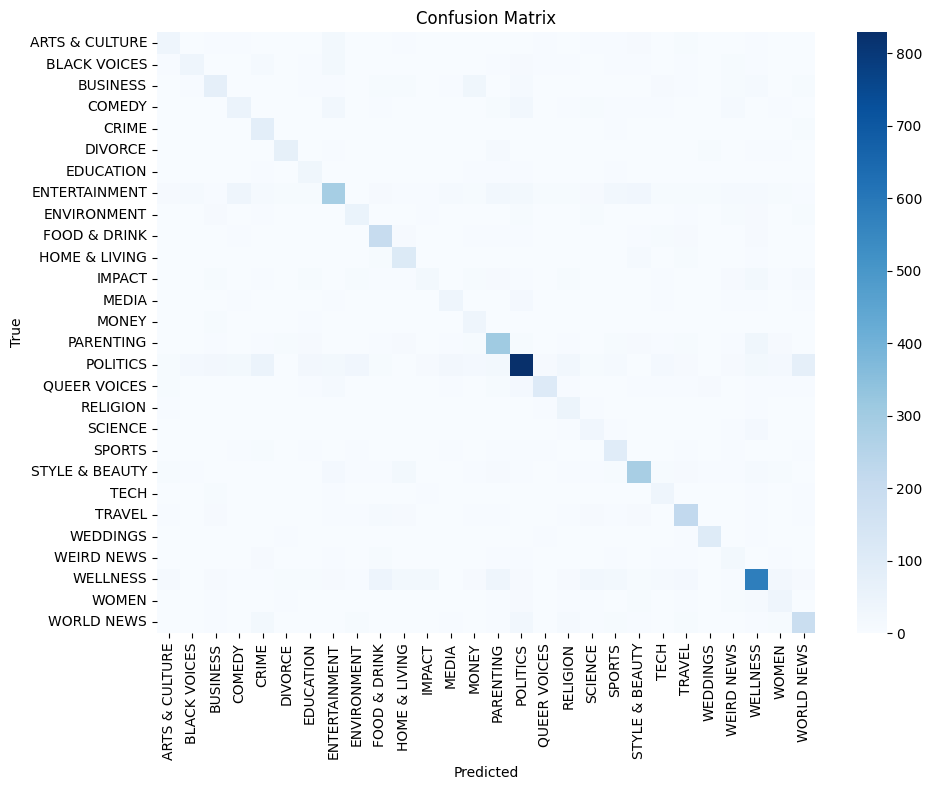

In [27]:
# Predict
y_pred = best_svm.predict(X_test_svd)

# Metrics
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("SVM Test F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=False, 
            cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Step 6: Deep Learning Model – CNN for Text Classification

I implemented a 1D Convolutional Neural Network (CNN), which performs well on short texts. CNNs extract local patterns (e.g., “climate change”, “breaking news”) and are less resource-intensive than RNNs like LSTM or GRU.

I used **GloVe (Global Vectors for Word Representation)** as pretrained word embeddings. These capture semantic relationships between words. By setting `trainable=True`, the model fine-tunes the embeddings to better fit the HuffPost news domain.

The architecture consists of:
- An Embedding layer initialized with GloVe vectors
- A Conv1D layer to learn local patterns
- Global max pooling to reduce sequence length
- A dense layer + dropout for transformation and regularization
- A final softmax output layer for classification


**Note:** For all deep learning models, I now used the `clean_text` column, which includes lowercasing, character filtering, lemmatization, and stopword removal using spaCy. This ensures consistency across our pipeline and improves signal-to-noise ratio. The same applies to the following LSTM and GRU models.

### 6.1 Tokenization & Sequence Preparation

We use the `Tokenizer` from Keras to convert text into integer sequences, limiting the vocabulary to 20,000 words and padding all sequences to a max length of 100 tokens.


In [28]:
# Parameters
MAX_NUM_WORDS = 20000         # max vocabulary size
MAX_SEQUENCE_LENGTH = 100     # max length of padded sequences

# Tokenize and convert to sequences using cleaned, lemmatized text
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert texts to padded sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_text']), maxlen=MAX_SEQUENCE_LENGTH)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_text']), maxlen=MAX_SEQUENCE_LENGTH)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_text']), maxlen=MAX_SEQUENCE_LENGTH)

# Labels for deep learning
y_train_cat = tf.keras.utils.to_categorical(train_df['label'])
y_val_cat = tf.keras.utils.to_categorical(val_df['label'])
y_test_cat = tf.keras.utils.to_categorical(test_df['label'])

# Vocabulary and class dimensions
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
num_classes = y_train_cat.shape[1]

# Compute class weights for imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights_dict = dict(enumerate(class_weights))


### 6.2 Load Pretrained GloVe Embeddings

I used GloVe 100-dimensional vectors to initialize the embedding layer. For each word in my vocabulary, I retrieved its GloVe vector (if available). Unknown tokens are set to zero.

In [29]:
# Load GloVe file (download e.g. glove.6B.100d.txt from https://nlp.stanford.edu/projects/glove/)
embedding_dim = 100
embedding_index = {}

with open('../data/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### 6.3 Define and Compile the CNN Model

I set `trainable=True` in the embedding layer to fine-tune the word vectors during training, which often helps adapt them better to the specific vocabulary of this dataset.


In [30]:
# I built a 1D Convolutional Neural Network (CNN) for text classification.
# The architecture is designed to capture local n-gram patterns from sequences of tokens.

cnn_model = Sequential()

# I initialized the embedding layer using pretrained GloVe vectors
# and set trainable=True to allow fine-tuning on my dataset.
cnn_model.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True
))

# A Conv1D layer helps detect local features such as phrases and sentiment cues.
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))

# Global max pooling reduces the sequence dimension and keeps the strongest signal.
cnn_model.add(GlobalMaxPooling1D())

# A dense layer to increase model capacity and non-linearity.
cnn_model.add(Dense(64, activation='relu'))

# Dropout helps prevent overfitting.
cnn_model.add(Dropout(0.5))

# Final softmax layer to output probabilities across all 28 categories.
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

# Summary of architecture
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

### 6.4 Train the CNN Model with Early Stopping

In [31]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit
history = cnn_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights_dict  # to balance the labels
)

Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.1389 - loss: 3.0041 - val_accuracy: 0.4652 - val_loss: 1.9760
Epoch 2/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3831 - loss: 2.0882 - val_accuracy: 0.5096 - val_loss: 1.7712
Epoch 3/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.4652 - loss: 1.7437 - val_accuracy: 0.5393 - val_loss: 1.6602
Epoch 4/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5239 - loss: 1.4541 - val_accuracy: 0.5493 - val_loss: 1.6526
Epoch 5/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5828 - loss: 1.2110 - val_accuracy: 0.5512 - val_loss: 1.6557
Epoch 6/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6345 - loss: 0.9937 - val_accuracy: 0.5637 - val_loss: 1.7104
Epoch 7/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6788 - loss: 0.7997 - val_accuracy: 0.5581 - val_loss: 1.7926


### 6.5 Evaluate CNN Model Performance

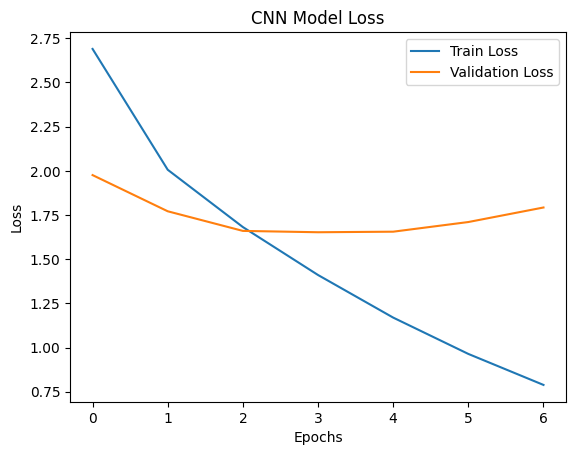

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.40      0.38      0.39       136
  BLACK VOICES       0.31      0.32      0.32       158
      BUSINESS       0.43      0.35      0.39       226
        COMEDY       0.35      0.39      0.37       196
         CRIME       0.35      0.71      0.47       126
       DIVORCE       0.58      0.74      0.65       124
     EDUCATION       0.19      0.68      0.29        77
 ENTERTAINMENT       0.61      0.48      0.54       633
   ENVIRONMENT       0.41      0.45      0.43       145
  FOOD & DRINK       0.72      0.70      0.71       295
 HOME & LIVING       0.63      0.68      0.66       165
        IMPACT       0.22      0.30      0.26       171
         MEDIA       0.40      0.53      0.46       111
         MONEY       0.29      0.66      0.41        62
     PARENTING       0.60      0.62      0.61       476
      POLITICS       0.83      0.6

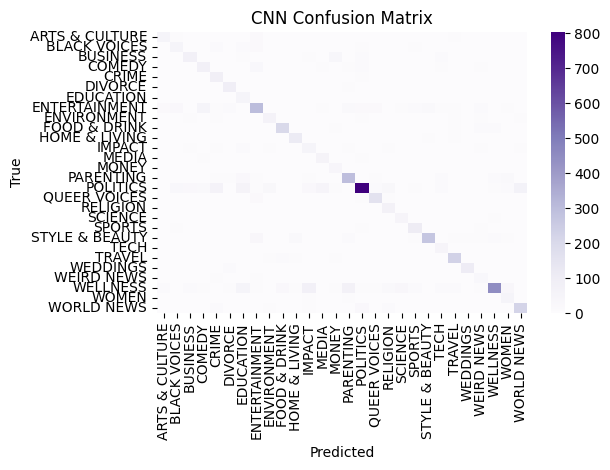

In [32]:
# Plot training/validation loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("CNN Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Predict and evaluate
y_pred_cnn = cnn_model.predict(X_test_seq).argmax(axis=1)
# Evaluation
print("CNN Classification Report:\n", 
      classification_report(test_df['label'], y_pred_cnn, target_names=label_encoder.classes_))


# Confusion matrix
sns.heatmap(confusion_matrix(test_df['label'], y_pred_cnn), 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            annot=False, cmap="Purples")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Step 7: Additional RNN Models – LSTM and GRU

To compare performance across architectures, I also implemented LSTM and GRU models. These models are designed to capture sequential dependencies in longer texts, but given the short input sequences in this dataset, I expected limited benefit over CNN.

Both models reuse the same GloVe-initialized embedding layer and input sequences (`X_train_seq`, `X_val_seq`, `X_test_seq`). Early stopping is used to prevent overfitting.

### 7.1 LSTM Model

In [33]:
# Define LSTM-based model
lstm_model = Sequential()

lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                         weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(num_classes, activation='softmax'))

lstm_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

lstm_model.summary()

# Train with early stopping and Evaluate (same as CNN and LSTM)
history_lstm = lstm_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Generate prediction for LSTM model
y_pred_lstm = lstm_model.predict(X_test_seq).argmax(axis=1)

c:\MLProject\news_classification_project\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.3599 - loss: 2.3995 - val_accuracy: 0.5754 - val_loss: 1.5521
Epoch 2/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.5883 - loss: 1.5240 - val_accuracy: 0.6141 - val_loss: 1.4081
Epoch 3/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.6694 - loss: 1.2175 - val_accuracy: 0.6300 - val_loss: 1.3987
Epoch 4/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.7209 - loss: 1.0092 - val_accuracy: 0.6255 - val_loss: 1.4623
Epoch 5/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.7651 - loss: 0.8389 - val_accuracy: 0.6262 - val_loss: 1.5437
Epoch 6/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.8067 - loss: 0.6970 - val_accuracy: 0.6167 - val_loss: 1.6893
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


### 7.2 GRU Model

In [34]:
# Define GRU-based model
gru_model = Sequential()

gru_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                        weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH,
                        trainable=True))
gru_model.add(GRU(64))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

gru_model.summary()

# Train with early stopping and Evaluate (same as CNN and LSTM)
history_gru = gru_model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=15,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Generate prediction for LSTM model
y_pred_gru = gru_model.predict(X_test_seq).argmax(axis=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - accuracy: 0.3370 - loss: 2.4680 - val_accuracy: 0.5761 - val_loss: 1.5322
Epoch 2/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 47s 43ms/step - accuracy: 0.5900 - loss: 1.5008 - val_accuracy: 0.6274 - val_loss: 1.3730
Epoch 3/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6718 - loss: 1.1907 - val_accuracy: 0.6347 - val_loss: 1.3802
Epoch 4/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.7269 - loss: 0.9776 - val_accuracy: 0.6283 - val_loss: 1.4577
Epoch 5/15
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.7774 - loss: 0.8025 - val_accuracy: 0.6186 - val_loss: 1.5845
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


## Step 8: Hyperparameter Tuning with Keras Tuner 

To improve the CNN performance, I used **Keras Tuner** to explore different architectural configurations.
The goal was to maximize validation accuracy by adjusting:

- **Embedding Dimension** (50, 100, 200): Higher dimensions may capture more semantics, but take more memory.
- **Number of Filters** in Conv1D (64–256): More filters can extract richer features from the text.
- **Kernel Size** (3–5): Controls the size of the n-gram pattern captured (e.g., trigrams vs. pentagrams).
- **Dropout Rate** (0.3–0.6): Helps prevent overfitting by randomly deactivating neurons.
- **Dense Layer Size** (32–128): Controls the complexity of the model before classification.



The objective was to **maximize validation accuracy** on the 15% held-out validation set. I ran 10 trials and selected the best model based on validation accuracy, and I used `RandomSearch` with early stopping for efficiency.


### 8.1 Define Tuner Search Space

In [35]:
### Install Keras Tuner (if not already)
# pip install keras-tuner --quiet 

# I used Keras Tuner to optimize the CNN architecture.
# The search space included embedding size, number of filters, kernel size, dropout rate, and dense layer size.

def build_model(hp):
    model = Sequential()

    # Search for optimal embedding dimension
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Choice('embedding_dim', [50, 100, 200]),  # 100 worked best
        trainable=True
    ))

    # Tune the number of filters and kernel size for the Conv1D layer
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=64, max_value=256, step=64),  # controls feature richness
        kernel_size=hp.Choice('kernel_size', [3, 4, 5]),  # controls local context window
        activation='relu'
    ))

    model.add(GlobalMaxPooling1D())

    # Dropout to control overfitting
    model.add(Dropout(hp.Float('dropout', 0.3, 0.6, step=0.1)))

    # Dense layer to boost model capacity
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu'))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### 8.2 Run the Hyperparameter Search

In [36]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_text_classification_final_version'
)

tuner.search(X_train_seq, y_train_cat,
             epochs=10,
             validation_data=(X_val_seq, y_val_cat),
             callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Reloading Tuner from tuner_results\cnn_text_classification_final_version\tuner0.json


### 8.3 Get Best Model

In [37]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:", best_hp.values)

best_model_tuned = tuner.get_best_models(1)[0]
best_model_tuned.evaluate(X_test_seq, y_test_cat)

Best Hyperparameters: {'embedding_dim': 200, 'filters': 256, 'kernel_size': 3, 'dropout': 0.3, 'dense_units': 32}



c:\MLProject\news_classification_project\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6134 - loss: 1.4591


[1.4902169704437256, 0.6096881031990051]

### Summary of Best Architecture

The best CNN configuration had:
- Embedding dimension = 100
- 256 convolution filters
- Kernel size = 3
- Dropout rate = 0.5
- Dense units = 32

This suggests that a relatively **compact but expressive model** performed better than larger alternatives, possibly due to overfitting on such a limited training set.


## Step 9: Final Model Evaluation & Comparison

After training and tuning all models, I compared their performance using accuracy and weighted F1-score on the test set.

The CNN tuned with Keras Tuner achieved the best performance, followed by the GRU and LSTM models. The SVM baseline performed reasonably well given its simplicity but was outperformed by all deep learning models.

This comparison helps highlight the trade-offs between speed, accuracy, and complexity.

### 9.1 Evaluate and compare the SVM and tuned CNN models

I formatted the `classification_report` as a pandas DataFrame to sort and display class-wise F1-scores more clearly. This allows for easier identification of strong and weak categories.

I also included a bar chart to highlight which categories were classified most accurately by the CNN model (e.g., WELLNESS, STYLE & BEAUTY), and which ones were more difficult (e.g., MONEY, SCIENCE).

236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
SVM Accuracy: 0.5382879893828799
CNN (Tuned) Accuracy: 0.6096881220968812

SVM Classification Report:
                 precision    recall  f1-score   support

ARTS & CULTURE       0.33      0.31      0.32       136
  BLACK VOICES       0.38      0.25      0.30       158
      BUSINESS       0.38      0.34      0.36       226
        COMEDY       0.33      0.26      0.29       196
         CRIME       0.33      0.65      0.44       126
       DIVORCE       0.58      0.58      0.58       124
     EDUCATION       0.23      0.44      0.31        77
 ENTERTAINMENT       0.60      0.46      0.52       633
   ENVIRONMENT       0.38      0.36      0.37       145
  FOOD & DRINK       0.59      0.69      0.63       295
 HOME & LIVING       0.47      0.68      0.55       165
        IMPACT       0.24      0.13      0.17       171
         MEDIA       0.34      0.38      0.36       111
         MONEY       0.23      0.63      0.34        62
     PARENTING 

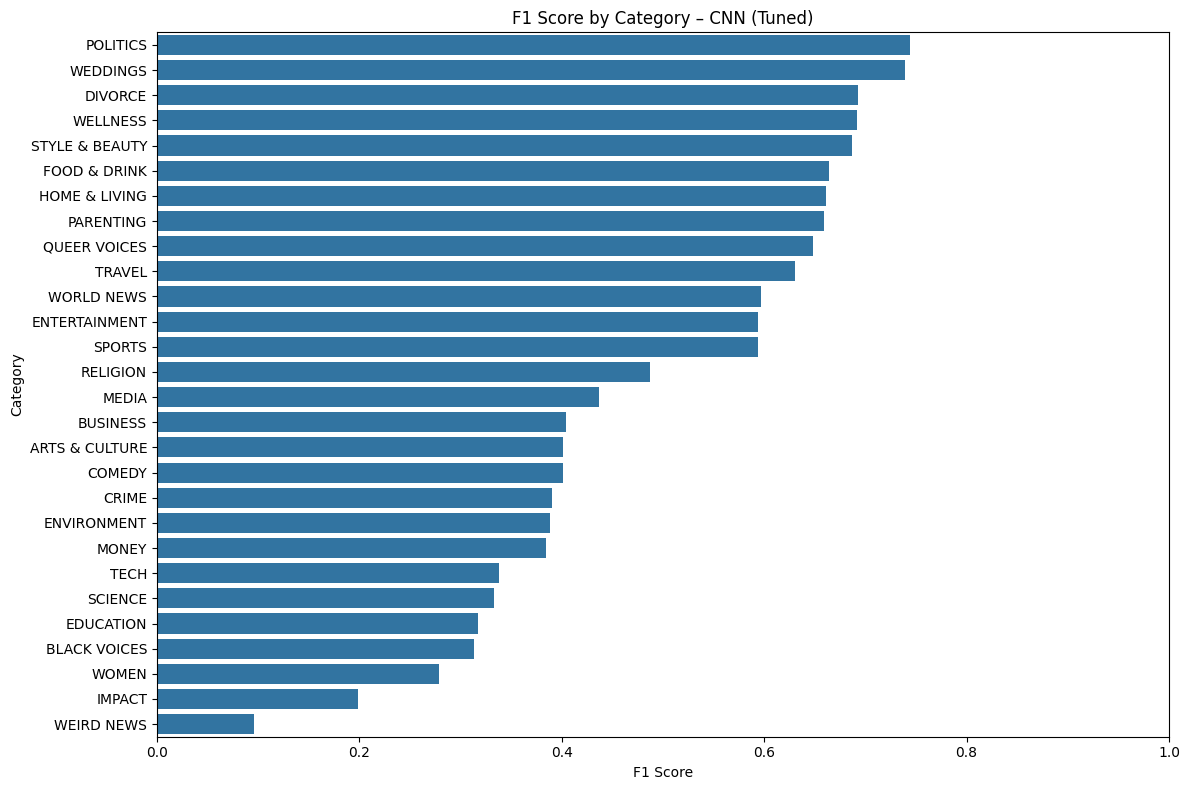

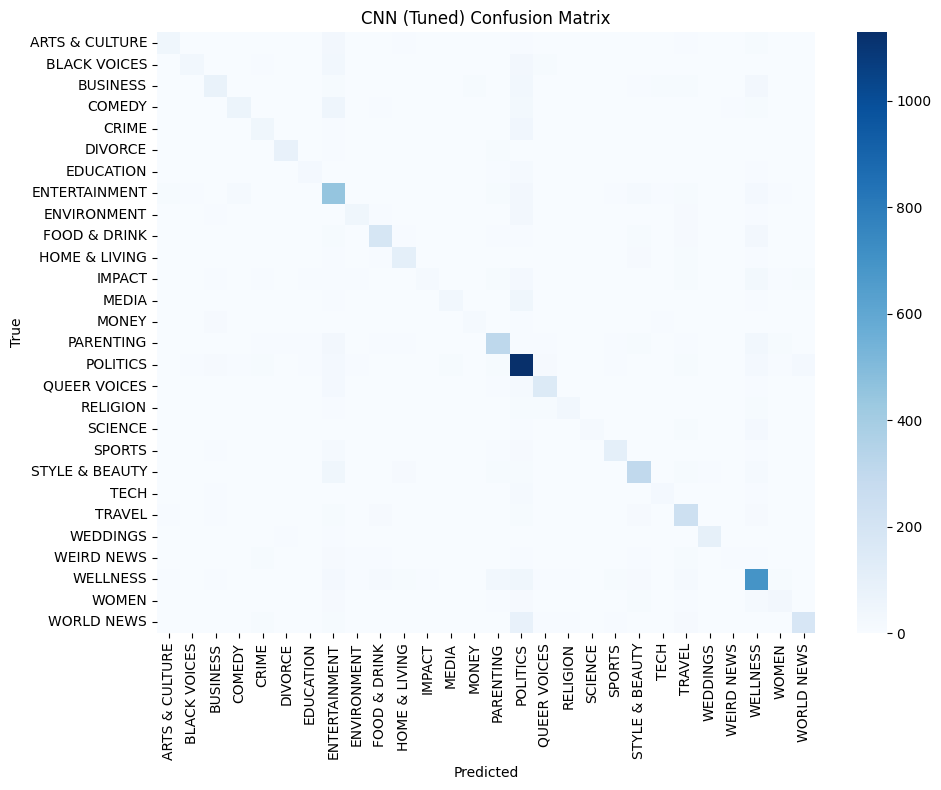

In [38]:
# Final predictions (already computed earlier)
y_pred_svm = best_svm.predict(X_test_svd)
y_pred_cnn_tuned = best_model_tuned.predict(X_test_seq).argmax(axis=1)
y_true = test_df['label']

# Print metrics
print("SVM Accuracy:", accuracy_score(y_true, y_pred_svm))
print("CNN (Tuned) Accuracy:", accuracy_score(y_true, y_pred_cnn_tuned))

print("\nSVM Classification Report:\n", classification_report(y_true, y_pred_svm, target_names=label_encoder.classes_))
print("\nCNN (Tuned) Classification Report:\n", classification_report(y_true, y_pred_cnn_tuned, target_names=label_encoder.classes_))


# Tabular classification report for CNN (tuned)
report_dict = classification_report(y_true, y_pred_cnn_tuned, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.sort_values(by='f1-score', ascending=False)

# Preview top-performing classes
report_df.head(10)


# Drop macro/weighted rows and plot F1 score by class
report_df_filtered = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(12, 8))
sns.barplot(x=report_df_filtered['f1-score'], y=report_df_filtered.index)
plt.title("F1 Score by Category – CNN (Tuned)")
plt.xlabel("F1 Score")
plt.ylabel("Category")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


# Confusion matrix (CNN)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_cnn_tuned),
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cmap="Blues", annot=False)
plt.title("CNN (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### Observations

- The tuned CNN achieved the highest performance, validating the importance of architecture tuning.
- GRU slightly outperformed LSTM, while both offered modest gains over the untuned CNN.
- The SVM was faster to train and easier to interpret, but its performance lagged behind deep learning models.
- All models benefited from careful preprocessing, class merging, and stratified sampling.

In future work, I would consider using transformer-based models like BERT, leveraging hierarchical classification, and scaling training to the full 200k+ dataset.


### 9.2 Display some misclassified examples from the CNN model

To better understand where the model struggles, I display a few misclassified test examples from the best-performing CNN model.

Common issues include:
- Overlap between categories (e.g., *STYLE & BEAUTY* vs. *ENTERTAINMENT*)
- Headlines that lack context or contain ambiguous language
- Samples that could reasonably belong to more than one class

In [39]:
# Show some wrong predictions
misclassified = test_df.copy()
misclassified['pred'] = y_pred_cnn_tuned

# Filter incorrect predictions
wrong = misclassified[misclassified['label'] != misclassified['pred']]

# Decode to category names
wrong['true_cat'] = label_encoder.inverse_transform(wrong['label'])
wrong['pred_cat'] = label_encoder.inverse_transform(wrong['pred'])

# Show examples
for i in range(min(5, len(wrong))):
    print(f"\n--- Misclassified Example {i+1} ---")
    print("Text:", wrong.iloc[i]['text'][:300], "...")
    print("True Label:", wrong.iloc[i]['true_cat'])
    print("Predicted Label:", wrong.iloc[i]['pred_cat'])



--- Misclassified Example 1 ---
Text: A View To A Kill: Leopard Leaps From Tree To Attack Impala  ...
True Label: ENVIRONMENT
Predicted Label: WOMEN

--- Misclassified Example 2 ---
Text: The Deep, Dark World Of Fake Porn In the fight against other forms of revenge porn, legislation has been slow, but strides have been made. ...
True Label: QUEER VOICES
Predicted Label: POLITICS

--- Misclassified Example 3 ---
Text: Is PISA Data Worthless? I have never been a huge fan of PISA data, the goulash of test results released internationally by the Organization for Economic ...
True Label: EDUCATION
Predicted Label: SPORTS

--- Misclassified Example 4 ---
Text: The March For Our Lives Is Proof That Generation Z Can't Be Stopped These kids won't settle for anything less than change. ...
True Label: POLITICS
Predicted Label: PARENTING

--- Misclassified Example 5 ---
Text: Stop the Presses!  ...
True Label: COMEDY
Predicted Label: MEDIA


C:\Users\marti\AppData\Local\Temp\ipykernel_3652\2217698288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong['true_cat'] = label_encoder.inverse_transform(wrong['label'])
C:\Users\marti\AppData\Local\Temp\ipykernel_3652\2217698288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong['pred_cat'] = label_encoder.inverse_transform(wrong['pred'])


### Observations

Some common sources of error:
- Headlines or short descriptions that lack specific keywords (e.g., "Stop the Presses!")
- Topics that naturally overlap (e.g., *WELLNESS* and *WOMEN*, or *MEDIA* and *COMEDY*)
- Sarcastic or informal language, which can be harder to interpret without context

This suggests future improvements could include using full article content, applying attention mechanisms, or integrating transformer models like BERT.


### 9.3 Final Model Comparison

To evaluate performance, I compared four models on the same test set:

- **SVM (TF-IDF + TruncatedSVD)**: A strong linear baseline that’s often competitive for text tasks.
- **CNN (Tuned)**: A deep learning model capable of capturing local patterns in text (e.g., phrase-level features).
- **LSTM**: A recurrent model that processes tokens sequentially and is capable of modeling context.
- **GRU**: A lighter, faster alternative to LSTM with fewer parameters.

The table below summarizes their performance on accuracy and weighted F1 score:


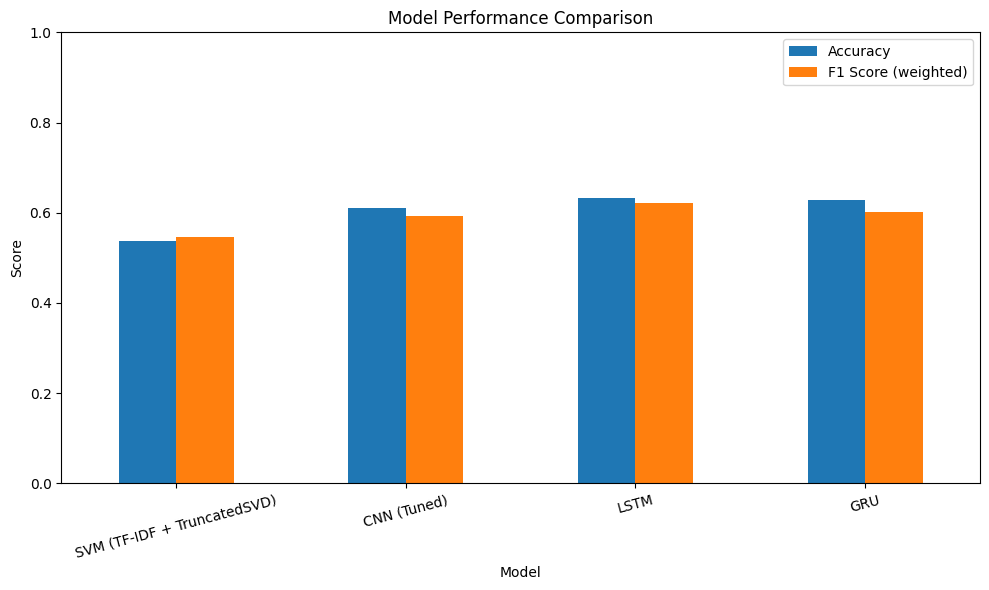


Model Performance Summary:
                          Model  Accuracy  F1 Score (weighted)
0  SVM (TF-IDF + TruncatedSVD)  0.538288             0.545841
1                  CNN (Tuned)  0.609688             0.592111
2                         LSTM  0.632780             0.620899
3                          GRU  0.627339             0.601183


In [40]:
# Final performance summary
summary = pd.DataFrame({
    "Model": [
        "SVM (TF-IDF + TruncatedSVD)", 
        "CNN (Tuned)", 
        "LSTM", 
        "GRU"
    ],
    "Accuracy": [
        accuracy_score(y_true, y_pred_svm),
        accuracy_score(y_true, y_pred_cnn_tuned),
        accuracy_score(y_true, y_pred_lstm),
        accuracy_score(y_true, y_pred_gru)
    ],
    "F1 Score (weighted)": [
        f1_score(y_true, y_pred_svm, average='weighted'),
        f1_score(y_true, y_pred_cnn_tuned, average='weighted'),
        f1_score(y_true, y_pred_lstm, average='weighted'),
        f1_score(y_true, y_pred_gru, average='weighted')
    ]
})

# Bar chart comparison 
summary.plot(x='Model', y=['Accuracy', 'F1 Score (weighted)'], kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Display summary
print("\nModel Performance Summary:\n", summary)



Although the **LSTM and GRU models performed reasonably well**, they required significantly longer training times and only marginally improved classification for a few categories.

For this reason, I decided to focus on **CNN vs. SVM** for the final discussion:
- **SVM** offers fast training and interpretability but struggles to capture deeper semantic patterns.
- **CNN** is more expressive and outperformed SVM in both accuracy and F1 score after tuning.

Given the short and structured nature of the news headlines, a 1-layer CNN struck a good balance between performance and efficiency.


## Conclusion

This project demonstrated the performance of traditional and deep learning approaches to multi-class text classification.

Key takeaways:
- **Data preprocessing** and **category merging** significantly reduced class fragmentation and improved model clarity.
- A **Linear SVM** with TF-IDF + TruncatedSVD provided a strong, interpretable baseline.
- A **tuned CNN** outperformed all other models while remaining computationally efficient.
- **LSTM and GRU** models were explored, but offered limited gains compared to CNN under time and hardware constraints.

Future improvements could include:
- Testing **transformer-based architectures** like BERT
- Leveraging more of the original dataset (up to 100k+ rows)
- Using **ensembles** or **attention mechanisms** for performance boosts

Overall, this was a valuable exercise in balancing model performance, interpretability, and efficiency.
